<a href="https://colab.research.google.com/github/iopebiel/machine_learning_fraud_credit_card/blob/randomForest/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imblearn
from sklearn.metrics import roc_auc_score
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, matthews_corrcoef
import pandas as pd
import seaborn as sn
import kagglehub as kh
import matplotlib.pyplot as plt
import os

Download Arquivo CSV no repositório Credit Card Fraud na plataforma Kaggle

In [2]:
path = kh.dataset_download("mlg-ulb/creditcardfraud")

print("Caminho para o Dataset:", path)
os.listdir(path)

Caminho para o Dataset: /kaggle/input/creditcardfraud


['creditcard.csv']

In [3]:
data = pd.read_csv("../kaggle/input/creditcardfraud/creditcard.csv")
data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


## Pré processamento dos dados

In [4]:
number_of_fraud = len(data[data.Class == 1])
number_of_normal= len(data[data.Class == 0])

print ("Fraude:", number_of_fraud)
print ("Legítima:",number_of_normal)

Fraude: 492
Legítima: 284315


In [5]:
X = data.drop("Class", axis=1)
y = data["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
counter = Counter(y_train)
print('Base de dados de treino antes do SMOTE:', counter)
counter = Counter(y_test)
print('Base de dados de teste', counter)

Base de dados de treino antes do SMOTE: Counter({0: 199020, 1: 344})
Base de dados de teste Counter({0: 85295, 1: 148})


##SMOTE 50:50

In [7]:
enn = EditedNearestNeighbours()
X_train_resampled, y_train_resampled = enn.fit_resample(X_train, y_train)
print('Base de treino depois do ENN:', Counter(y_train_resampled))

smt = SMOTE(random_state=42)
X_train_sm_5050, y_train_sm_5050 = smt.fit_resample(X_train_resampled, y_train_resampled)
counter = Counter(y_train_sm_5050)
print('Depois do SMOTE:', counter)

Base de treino depois do ENN: Counter({0: 198698, 1: 344})
Depois do SMOTE: Counter({0: 198698, 1: 198698})


##SMOTE 10 : 90

In [8]:
enn = EditedNearestNeighbours()
X_train_enn, y_train_enn = enn.fit_resample(X_train, y_train)
print('Depois do ENN:', Counter(y_train_enn))

smt = SMOTE(random_state=42, sampling_strategy=0.111)
X_train_sm_1090, y_train_sm_1090 = smt.fit_resample(X_train_enn, y_train_enn)
counter = Counter(y_train_sm_1090)
print('Depois do SMOTE:', counter)

Depois do ENN: Counter({0: 198698, 1: 344})
Depois do SMOTE: Counter({0: 198698, 1: 22055})


#MODELO TREINAMENTO SEM SMOTE

#####**MODELO 1 SCIKIT LEARN PURO**

In [ ]:
model = RandomForestClassifier(n_estimators=1000 ,class_weight={0: 1, 1: 10}, verbose=1, n_jobs=100) #Quanto maior o número de iterações, melhor o resultado

model.fit(X_train,y_train)
y_pred_rl = model.predict(X_train)

print(classification_report(y_train, y_pred_rl))

[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done 250 tasks      | elapsed:  9.9min
[Parallel(n_jobs=100)]: Done 600 tasks      | elapsed: 21.4min
[Parallel(n_jobs=100)]: Done 1000 out of 1000 | elapsed: 33.1min finished
[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done 250 tasks      | elapsed:    4.2s
[Parallel(n_jobs=100)]: Done 600 tasks      | elapsed:    9.0s


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       1.00      1.00      1.00       344

    accuracy                           1.00    199364
   macro avg       1.00      1.00      1.00    199364
weighted avg       1.00      1.00      1.00    199364



[Parallel(n_jobs=100)]: Done 1000 out of 1000 | elapsed:   14.3s finished


In [ ]:
print(X_test)
resultado_rl = model.predict(X_test)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .

[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done 251 tasks      | elapsed:    3.0s
[Parallel(n_jobs=100)]: Done 601 tasks      | elapsed:    5.3s
[Parallel(n_jobs=100)]: Done 1000 out of 1000 | elapsed:    7.2s finished



MÉTRICAS TREINAMENTO SEM SMOTE



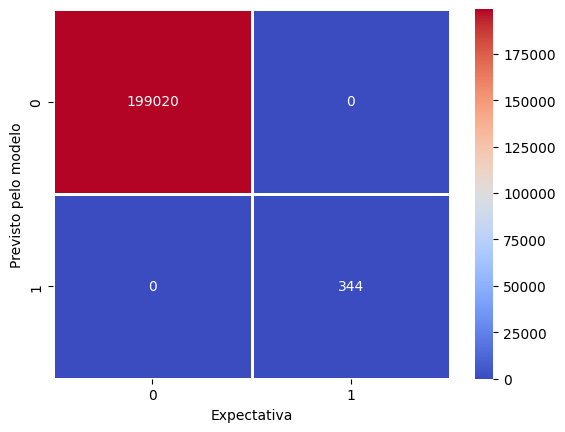

Acurácia: 100.000000%
Precisão: 100.000000%
Recall:  100.000000%
F1 Score:  100.000000%
MCC:  100.000000%

MÉTRICAS TESTE SEM SMOTE



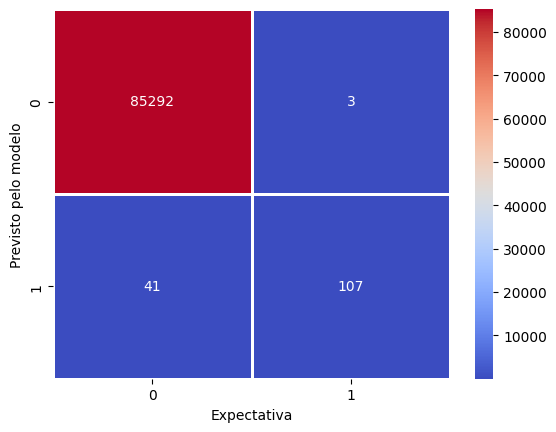

Acurácia: 99.948504%
Precisão: 97.272727%
Recall:  72.297297%
F1 Score:  82.945736%
MCC:  83.837579%

MÉTRICA AUC ROC

Treinamento:  1.0 
Teste: 0.8614689004615144


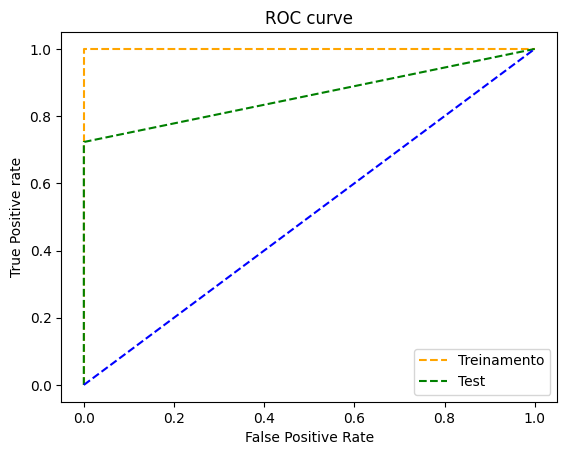

In [ ]:
cf_matrix = confusion_matrix(y_train, y_pred_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TREINAMENTO\n \nSEM SMOTE\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_train, y_pred_rl):%}')
print(f'Precisão: {precision_score(y_train, y_pred_rl):%}')
print(f'Recall:  {recall_score(y_train, y_pred_rl):%}')
print(f'F1 Score:  {f1_score(y_train, y_pred_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_train, y_pred_rl):%}')
cf_matrix = confusion_matrix(y_test, resultado_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TESTE\n \nSEM SMOTE\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_test, resultado_rl):%}')
print(f'Precisão: {precision_score(y_test, resultado_rl):%}')
print(f'Recall:  {recall_score(y_test, resultado_rl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_rl):%}')


print("\nMÉTRICA AUC ROC\n")
fpr1, tpr1, thresh1 = roc_curve(y_train, y_pred_rl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_rl, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score1 = roc_auc_score(y_train, y_pred_rl)
auc_score2 = roc_auc_score(y_test, resultado_rl)

print("Treinamento: ",auc_score1, "\nTeste:", auc_score2)

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC')
plt.show();

#####**MODELO 2 SCIKIT LEARN RAPIDS CUML**

In [9]:
model = cuRandomForestClassifier(verbose=1)
model.fit(X_train, y_train)
y_pred_curl = model.predict(X_train)

print(classification_report(y_train, y_pred_curl))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       1.00      0.97      0.99       344

    accuracy                           1.00    199364
   macro avg       1.00      0.99      0.99    199364
weighted avg       1.00      1.00      1.00    199364



In [10]:
print(X_test)
resultado_curl = model.predict(X_test)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .


MÉTRICAS TREINAMENTO
 
SEM SMOTE



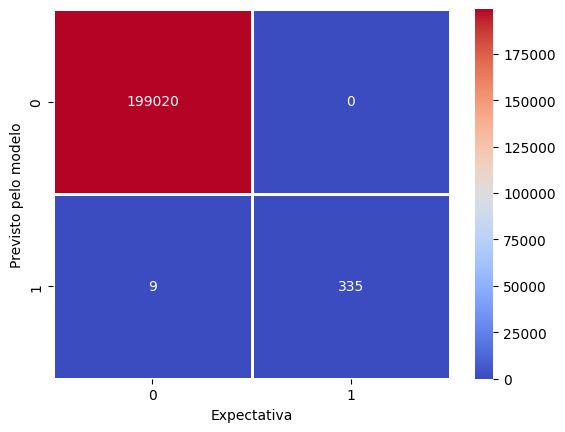

Acurácia: 99.995486%
Precisão: 100.000000%
Recall:  97.383721%
F1 Score:  98.674521%
MCC:  98.680959%

MÉTRICAS TESTE
 
SEM SMOTE



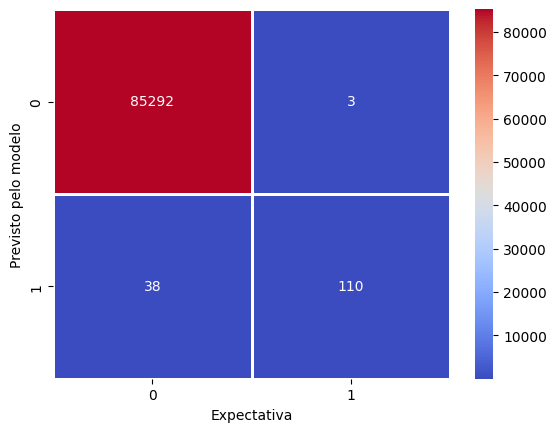

Acurácia: 99.952015%
Precisão: 97.345133%
Recall:  74.324324%
F1 Score:  84.291188%
MCC:  85.037986%

MÉTRICA AUC ROC

Treinamento:  0.9869186046511628 
Teste: 0.8716040355966495


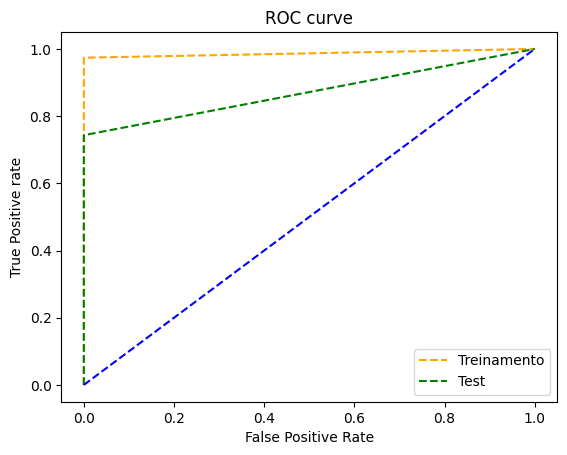

In [11]:
cf_matrix = confusion_matrix(y_train, y_pred_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TREINAMENTO\n \nSEM SMOTE\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_train, y_pred_curl):%}')
print(f'Precisão: {precision_score(y_train, y_pred_curl):%}')
print(f'Recall:  {recall_score(y_train, y_pred_curl):%}')
print(f'F1 Score:  {f1_score(y_train, y_pred_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_train, y_pred_curl):%}')
cf_matrix = confusion_matrix(y_test, resultado_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TESTE\n \nSEM SMOTE\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_test, resultado_curl):%}')
print(f'Precisão: {precision_score(y_test, resultado_curl):%}')
print(f'Recall:  {recall_score(y_test, resultado_curl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_curl):%}')


print("\nMÉTRICA AUC ROC\n")
fpr1, tpr1, thresh1 = roc_curve(y_train, y_pred_curl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_curl, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score1 = roc_auc_score(y_train, y_pred_curl)
auc_score2 = roc_auc_score(y_test, resultado_curl)

print("Treinamento: ",auc_score1, "\nTeste:", auc_score2)

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC')
plt.show();

#MODELO TREINAMENTO 10 : 90

#####**MODELO 1**

In [ ]:
model = RandomForestClassifier(n_estimators=1000, class_weight={0: 1, 1: 10}, verbose=1, n_jobs=100) #Quanto maior o número de iterações, melhor o resultado
model.fit(X_train_sm_1090, y_train_sm_1090)
y_pred_rl = model.predict(X_train_sm_1090)

print(classification_report(y_train_sm_1090, y_pred_rl))

[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done 250 tasks      | elapsed:  8.7min
[Parallel(n_jobs=100)]: Done 600 tasks      | elapsed: 18.6min
[Parallel(n_jobs=100)]: Done 1000 out of 1000 | elapsed: 28.9min finished
[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done 250 tasks      | elapsed:    5.9s
[Parallel(n_jobs=100)]: Done 600 tasks      | elapsed:   11.7s


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    198698
           1       1.00      1.00      1.00     22055

    accuracy                           1.00    220753
   macro avg       1.00      1.00      1.00    220753
weighted avg       1.00      1.00      1.00    220753



[Parallel(n_jobs=100)]: Done 1000 out of 1000 | elapsed:   18.4s finished


In [ ]:
print(X_test)
resultado_rl = model.predict(X_test)

[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.


            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .

[Parallel(n_jobs=100)]: Done 250 tasks      | elapsed:    1.8s
[Parallel(n_jobs=100)]: Done 600 tasks      | elapsed:    3.8s
[Parallel(n_jobs=100)]: Done 1000 out of 1000 | elapsed:    5.9s finished


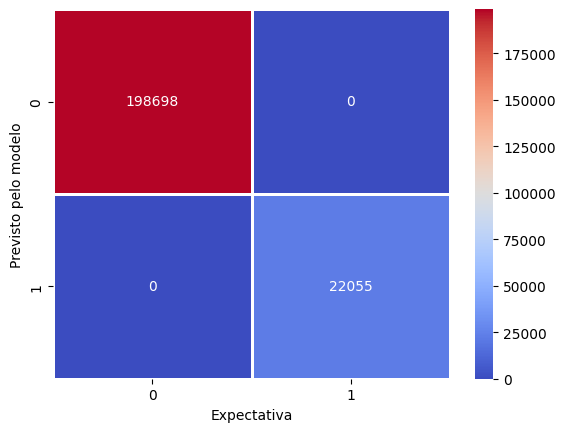


Métricas

Acurácia: 100.000000%
Precisão: 100.000000%
Recall:  100.000000%
F1 Score:  100.000000%
F1 Score:  100.000000%
MCC:  100.000000%


In [ ]:
cf_matrix = confusion_matrix(y_train_sm_1090, y_pred_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TREINAMENTO\n \nSMOTE 1090\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_train_sm_1090, y_pred_rl):%}')
print(f'Precisão: {precision_score(y_train_sm_1090, y_pred_rl):%}')
print(f'Recall:  {recall_score(y_train_sm_1090, y_pred_rl):%}')
print(f'F1 Score:  {f1_score(y_train_sm_1090, y_pred_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_train_sm_1090, y_pred_rl):%}')
cf_matrix = confusion_matrix(y_test, resultado_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TESTE\n \nSMOTE 1090\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_test, resultado_rl):%}')
print(f'Precisão: {precision_score(y_test, resultado_rl):%}')
print(f'Recall:  {recall_score(y_test, resultado_rl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_rl):%}')


print("\nMÉTRICA AUC ROC\n")
fpr1, tpr1, thresh1 = roc_curve(y_train_sm_1090, y_pred_rl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_rl, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score1 = roc_auc_score(y_train_sm_1090, y_pred_rl)
auc_score2 = roc_auc_score(y_test, resultado_rl)

print("Treinamento: ",auc_score1, "\nTeste:", auc_score2)

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC')
plt.show();

#####**MODELO 2**

In [12]:
model = cuRandomForestClassifier(max_iter=10000, solver='qn')  # qn é equivalente ao saga
model.fit(X_train_sm_1090, y_train_sm_1090)
y_pred_curl = model.predict(X_train_sm_1090)

print(classification_report(y_train_sm_1090, y_pred_curl))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    198698
           1       1.00      1.00      1.00     22055

    accuracy                           1.00    220753
   macro avg       1.00      1.00      1.00    220753
weighted avg       1.00      1.00      1.00    220753



In [13]:
print(X_test)
resultado_curl = model.predict(X_test)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .


MÉTRICAS TREINAMENTO
 
SMOTE 1090



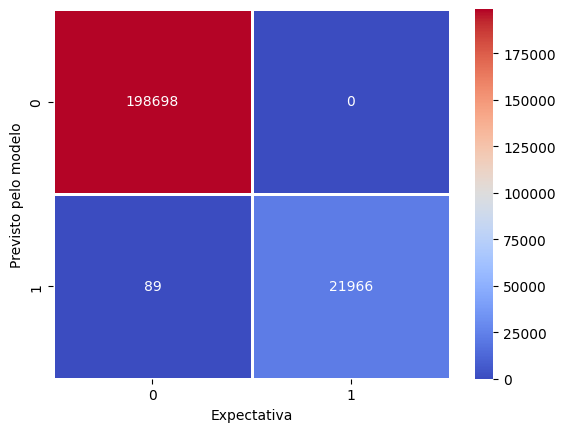

Acurácia: 99.959683%
Precisão: 100.000000%
Recall:  99.596463%
F1 Score:  99.797824%
MCC:  99.775685%

MÉTRICAS TESTE
 
SMOTE 1090



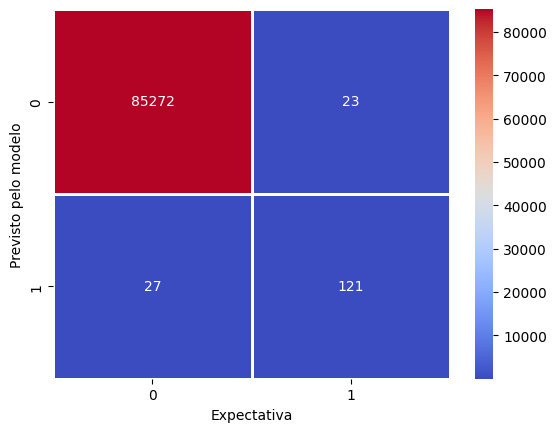

Acurácia: 99.941481%
Precisão: 84.027778%
Recall:  81.756757%
F1 Score:  82.876712%
MCC:  82.855209%

MÉTRICA AUC ROC

Treinamento:  0.9979823169349353 
Teste: 0.9086489575923306


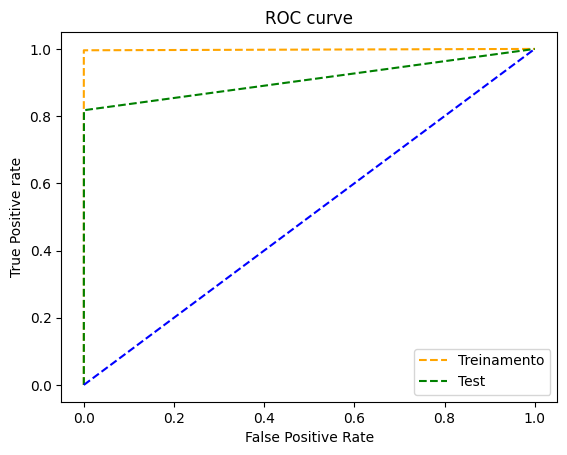

In [14]:
cf_matrix = confusion_matrix(y_train_sm_1090, y_pred_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TREINAMENTO\n \nSMOTE 1090\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_train_sm_1090, y_pred_curl):%}')
print(f'Precisão: {precision_score(y_train_sm_1090, y_pred_curl):%}')
print(f'Recall:  {recall_score(y_train_sm_1090, y_pred_curl):%}')
print(f'F1 Score:  {f1_score(y_train_sm_1090, y_pred_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_train_sm_1090, y_pred_curl):%}')
cf_matrix = confusion_matrix(y_test, resultado_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TESTE\n \nSMOTE 1090\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_test, resultado_curl):%}')
print(f'Precisão: {precision_score(y_test, resultado_curl):%}')
print(f'Recall:  {recall_score(y_test, resultado_curl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_curl):%}')


print("\nMÉTRICA AUC ROC\n")
fpr1, tpr1, thresh1 = roc_curve(y_train_sm_1090, y_pred_curl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_curl, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score1 = roc_auc_score(y_train_sm_1090, y_pred_curl)
auc_score2 = roc_auc_score(y_test, resultado_curl)

print("Treinamento: ",auc_score1, "\nTeste:", auc_score2)

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC')
plt.show();

#**MODELOS TREINAMENTO 50:50**

#####**MODELO 1**

In [ ]:
model = RandomForestClassifier(solver='saga', max_iter=6000, class_weight={0: 1, 1: 10}, verbose=1, n_jobs=100) #Quanto maior o número de iterações, melhor o resultado
model.fit(X_train_sm_5050,y_train_sm_5050)
y_pred_rl = model.predict(X_train_sm_5050)

print(classification_report(y_train_sm_5050, y_pred_rl))

TypeError: RandomForestClassifier.__init__() got an unexpected keyword argument 'solver'

In [ ]:
print(X_test)
resultado_rl = model.predict(X_test)

In [ ]:
cf_matrix = confusion_matrix(y_train_sm_5050, y_pred_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TREINAMENTO\n \nSMOTE 5050\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_train_sm_5050, y_pred_rl):%}')
print(f'Precisão: {precision_score(y_train_sm_5050, y_pred_rl):%}')
print(f'Recall:  {recall_score(y_train_sm_5050, y_pred_rl):%}')
print(f'F1 Score:  {f1_score(y_train_sm_5050, y_pred_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_train_sm_5050, y_pred_rl):%}')
cf_matrix = confusion_matrix(y_test, resultado_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TESTE\n \nSMOTE 5050\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_test, resultado_rl):%}')
print(f'Precisão: {precision_score(y_test, resultado_rl):%}')
print(f'Recall:  {recall_score(y_test, resultado_rl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_rl):%}')


print("\nMÉTRICA AUC ROC\n")
fpr1, tpr1, thresh1 = roc_curve(y_train_sm_5050, y_pred_rl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_rl, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score1 = roc_auc_score(y_train_sm_5050, y_pred_rl)
auc_score2 = roc_auc_score(y_test, resultado_rl)

print("Treinamento: ",auc_score1, "\nTeste:", auc_score2)

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC')
plt.show();

#####**MODELO 2**

In [15]:
model = cuRandomForestClassifier(verbose=1)
model.fit(X_train_sm_5050, y_train_sm_5050)
y_pred_curl = model.predict(X_train_sm_5050)

print(classification_report(y_train_sm_5050, y_pred_curl))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    198698
           1       1.00      1.00      1.00    198698

    accuracy                           1.00    397396
   macro avg       1.00      1.00      1.00    397396
weighted avg       1.00      1.00      1.00    397396



In [16]:
print(X_test)
resultado_curl = model.predict(X_test)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .


MÉTRICAS TREINAMENTO
 
SMOTE 1090



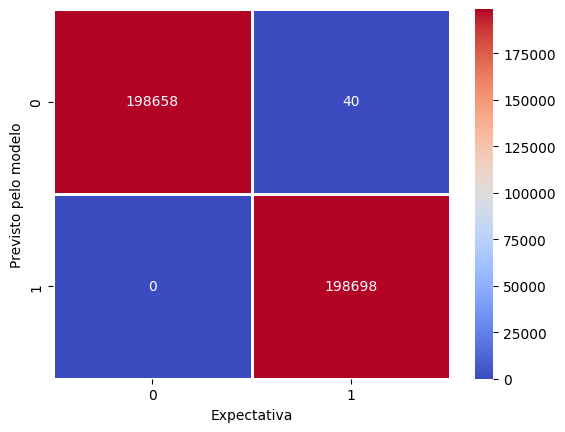

Acurácia: 99.989934%
Precisão: 99.979873%
Recall:  100.000000%
F1 Score:  99.989935%
MCC:  99.979871%

MÉTRICAS TESTE
 
SMOTE 5050



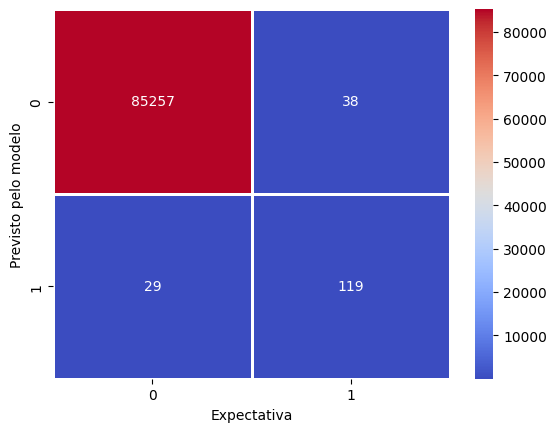

Acurácia: 99.921585%
Precisão: 75.796178%
Recall:  80.405405%
F1 Score:  78.032787%
MCC:  78.027643%

MÉTRICA AUC ROC

Treinamento:  0.9998993447342197 
Teste: 0.901804270710713


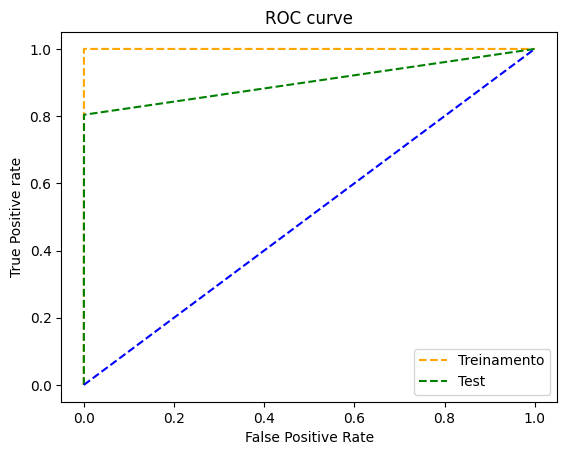

In [17]:
cf_matrix = confusion_matrix(y_train_sm_5050, y_pred_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TREINAMENTO\n \nSMOTE 1090\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_train_sm_5050, y_pred_curl):%}')
print(f'Precisão: {precision_score(y_train_sm_5050, y_pred_curl):%}')
print(f'Recall:  {recall_score(y_train_sm_5050, y_pred_curl):%}')
print(f'F1 Score:  {f1_score(y_train_sm_5050, y_pred_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_train_sm_5050, y_pred_curl):%}')
cf_matrix = confusion_matrix(y_test, resultado_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
print("\nMÉTRICAS TESTE\n \nSMOTE 5050\n")
plt.show()
print(f'Acurácia: {accuracy_score(y_test, resultado_curl):%}')
print(f'Precisão: {precision_score(y_test, resultado_curl):%}')
print(f'Recall:  {recall_score(y_test, resultado_curl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_curl):%}')


print("\nMÉTRICA AUC ROC\n")
fpr1, tpr1, thresh1 = roc_curve(y_train_sm_5050, y_pred_curl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_curl, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score1 = roc_auc_score(y_train_sm_5050, y_pred_curl)
auc_score2 = roc_auc_score(y_test, resultado_curl)

print("Treinamento: ",auc_score1, "\nTeste:", auc_score2)

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC')
plt.show();